In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv("Uber Cleaned Dataset.csv")
df.head()

,timestamp,date,hour,day_of_week,month,source,destination,ride_company,vehicle,visibility,...,distance,surge_multiplier,fare,humidity,wind_speed,weather_desc_short,weather_desc_long,weather_status,pressure,temperature_C
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,Lux Black,1.685,...,4.46,1.75,62.5,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1,5.46
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,Lux,1.685,...,4.46,1.75,47.5,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1,5.46
2,2018-11-26 03:40:46,2018-11-26,3,Monday,11,North Station,Fenway,Uber,WAV,1.685,...,3.05,1.00,10.5,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1,5.46
3,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Theatre District,Lyft,Lux Black XL,1.685,...,3.03,1.00,34.0,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1,5.46
4,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Northeastern University,Beacon Hill,Lyft,Lyft,1.685,...,2.43,1.00,10.5,0.92,0.51,Foggy,Rain in the morning and afternoon.,fog,1014.1,5.46


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637194 entries, 0 to 637193
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   timestamp           637194 non-null  object 
 1   date                637194 non-null  object 
 2   hour                637194 non-null  int64  
 3   day_of_week         637194 non-null  object 
 4   month               637194 non-null  int64  
 5   source              637194 non-null  object 
 6   destination         637194 non-null  object 
 7   ride_company        637194 non-null  object 
 8   vehicle             637194 non-null  object 
 9   visibility          637194 non-null  float64
 10  cloud_cover         637194 non-null  float64
 11  uv_index            637194 non-null  int64  
 12  distance            637194 non-null  float64
 13  surge_multiplier    637194 non-null  float64
 14  fare                637194 non-null  float64
 15  humidity            637194 non-nul

In [4]:
df.describe()

,hour,month,visibility,cloud_cover,uv_index,distance,surge_multiplier,fare,humidity,wind_speed,pressure,temperature_C
count,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000
mean,11.617813,11.586788,8.469312,0.686230,0.249075,2.165190,1.015086,16.544011,0.741046,6.200890,1010.098543,2.229213
std,6.948664,0.492411,2.601731,0.358629,0.474355,1.074128,0.095479,9.306944,0.138584,3.152245,13.474334,4.451707
min,0.000000,11.000000,0.717000,0.000000,0.000000,0.020000,1.000000,2.500000,0.380000,0.450000,988.090000,-11.040000
25%,6.000000,11.000000,8.432000,0.370000,0.000000,1.300000,1.000000,9.000000,0.640000,3.410000,999.840000,-0.050000
50%,12.000000,12.000000,9.880000,0.820000,0.000000,2.165190,1.000000,13.500000,0.710000,5.920000,1009.250000,2.210000
75%,18.000000,12.000000,9.996000,1.000000,0.000000,2.880000,1.000000,22.500000,0.880000,8.410000,1021.860000,4.840000
max,23.000000,12.000000,10.000000,1.000000,2.000000,6.130000,3.000000,80.000000,0.960000,15.850000,1035.550000,14.350000


In [5]:
df.isnull().sum()

timestamp             0
date                  0
hour                  0
day_of_week           0
month                 0
source                0
destination           0
ride_company          0
vehicle               0
visibility            0
cloud_cover           0
uv_index              0
distance              0
surge_multiplier      0
fare                  0
humidity              0
wind_speed            0
weather_desc_short    0
weather_desc_long     0
weather_status        0
pressure              0
temperature_C         0
dtype: int64

## Understanding the Target Variable — Fare

In this step, we aim to understand the distribution and behavior of the target variable `fare`. This includes:

- Plotting the histogram and boxplot to visually assess the distribution and detect potential outliers.
- Calculating key summary statistics such as mean, median, mode, and Interquartile Range (IQR).
- Checking skewness to understand the shape of the distribution (e.g., right-skewed or left-skewed).

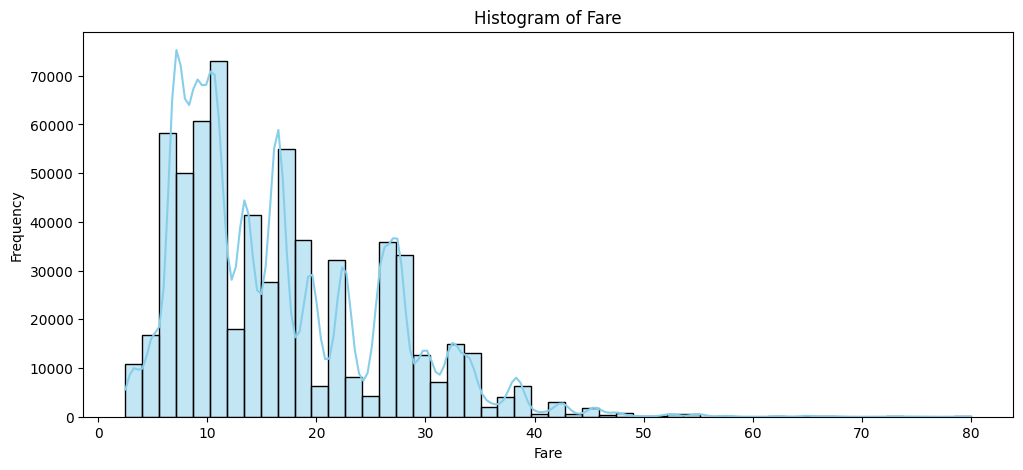

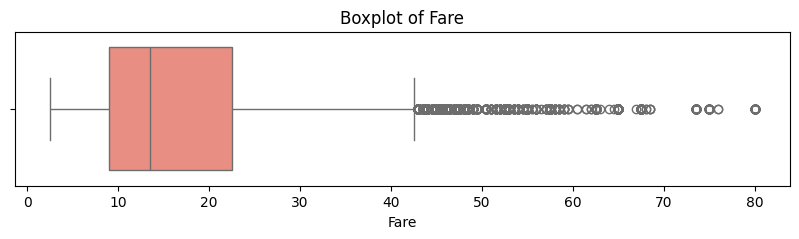

Mean Fare: 16.54
Median Fare: 13.50
Mode Fare: 7.00
Standard Deviation: 9.31
Q1: 9.00, Q3: 22.50, IQR: 13.50
Skewness: 1.02


In [6]:
# Plotting the histogram of fare
plt.figure(figsize=(12, 5))
sns.histplot(df["fare"], bins=50, kde=True, color="skyblue")
plt.title("Histogram of Fare")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.show()

# Plotting the boxplot of fare
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x="fare", color="salmon")
plt.title("Boxplot of Fare")
plt.xlabel("Fare")
plt.show()

# Calculate summary statistics
fare_mean = df["fare"].mean()
fare_median = df["fare"].median()
fare_mode = df["fare"].mode()[0]
fare_std = df["fare"].std()

# Interquartile Range (IQR)
Q1 = df["fare"].quantile(0.25)
Q3 = df["fare"].quantile(0.75)
IQR = Q3 - Q1

# Skewness
fare_skewness = df["fare"].skew()

print(f"Mean Fare: {fare_mean:.2f}")
print(f"Median Fare: {fare_median:.2f}")
print(f"Mode Fare: {fare_mode:.2f}")
print(f"Standard Deviation: {fare_std:.2f}")
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Skewness: {fare_skewness:.2f}")


## Step 3: Univariate Analysis of Features

In this step, we explore the distribution and characteristics of each individual feature in the dataset. The goal is to understand the data types, identify potential anomalies, and gain insights into the behavior of each variable.

We'll examine:
- **Numerical features** such as distance, temperature, humidity, etc.
- **Categorical features** such as vehicle type, source, destination, weather description, etc.






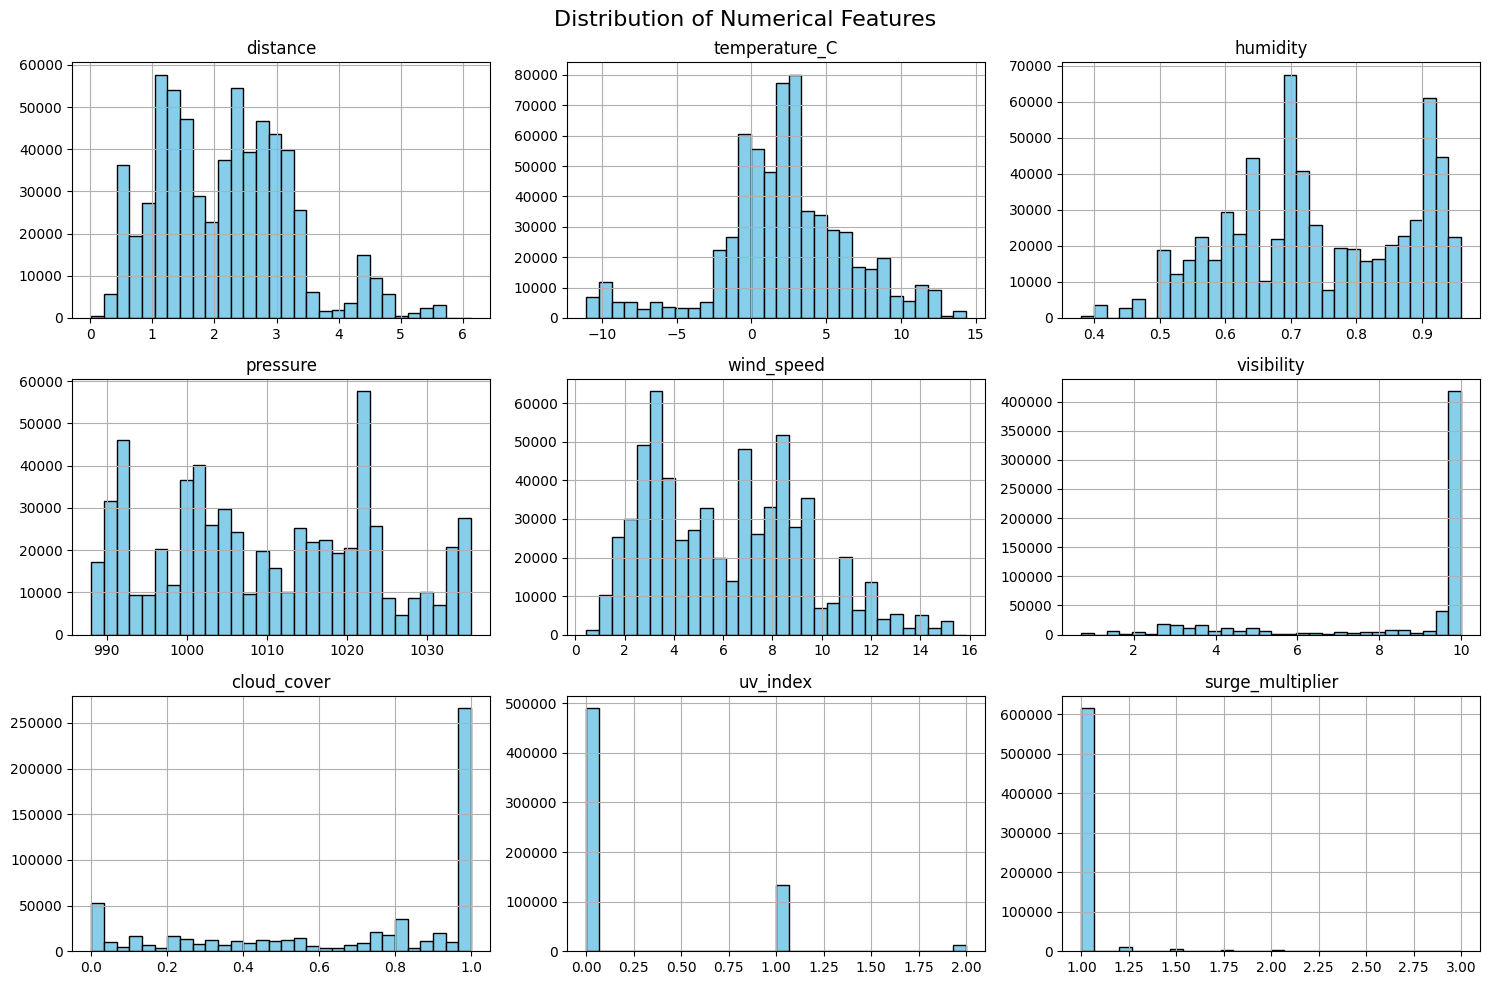

,distance,temperature_C,humidity,pressure,wind_speed,visibility,cloud_cover,uv_index,surge_multiplier
count,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000,637194.000000
mean,2.165190,2.229213,0.741046,1010.098543,6.200890,8.469312,0.686230,0.249075,1.015086
std,1.074128,4.451707,0.138584,13.474334,3.152245,2.601731,0.358629,0.474355,0.095479
min,0.020000,-11.040000,0.380000,988.090000,0.450000,0.717000,0.000000,0.000000,1.000000
25%,1.300000,-0.050000,0.640000,999.840000,3.410000,8.432000,0.370000,0.000000,1.000000
50%,2.165190,2.210000,0.710000,1009.250000,5.920000,9.880000,0.820000,0.000000,1.000000
75%,2.880000,4.840000,0.880000,1021.860000,8.410000,9.996000,1.000000,0.000000,1.000000
max,6.130000,14.350000,0.960000,1035.550000,15.850000,10.000000,1.000000,2.000000,3.000000


In [7]:
# List of numerical features (excluding target 'fare')
num_cols = ['distance', 'temperature_C', 'humidity', 'pressure', 'wind_speed', 'visibility', 'cloud_cover', 'uv_index','surge_multiplier']

# Plot histograms
df[num_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# Summary statistics
df[num_cols].describe()


/tmp/ipykernel_11823/2153719276.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


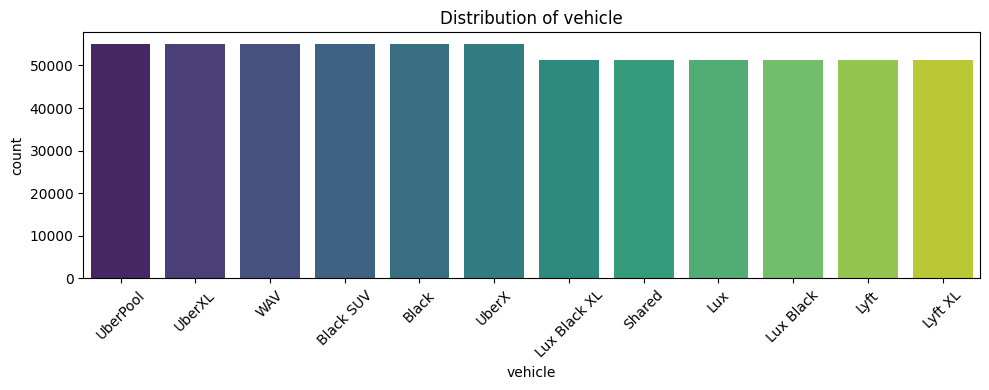

/tmp/ipykernel_11823/2153719276.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


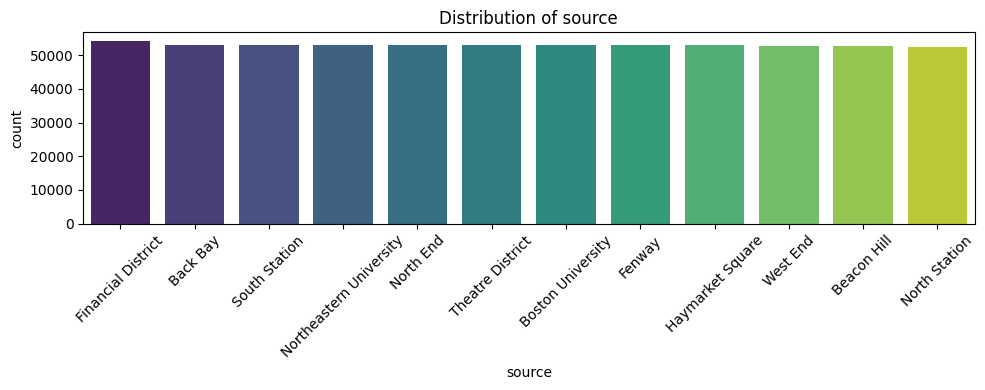

/tmp/ipykernel_11823/2153719276.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


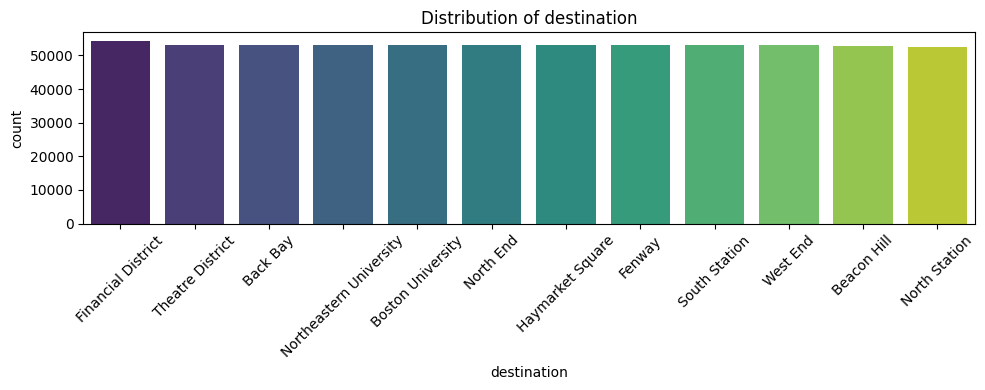

/tmp/ipykernel_11823/2153719276.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


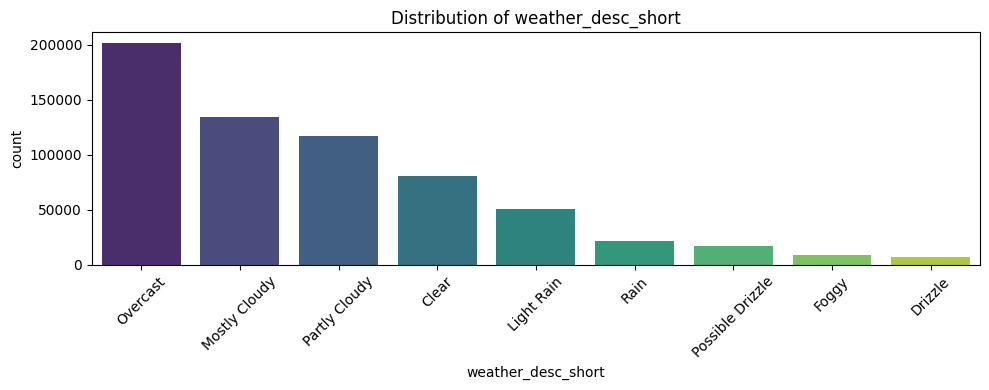

/tmp/ipykernel_11823/2153719276.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")


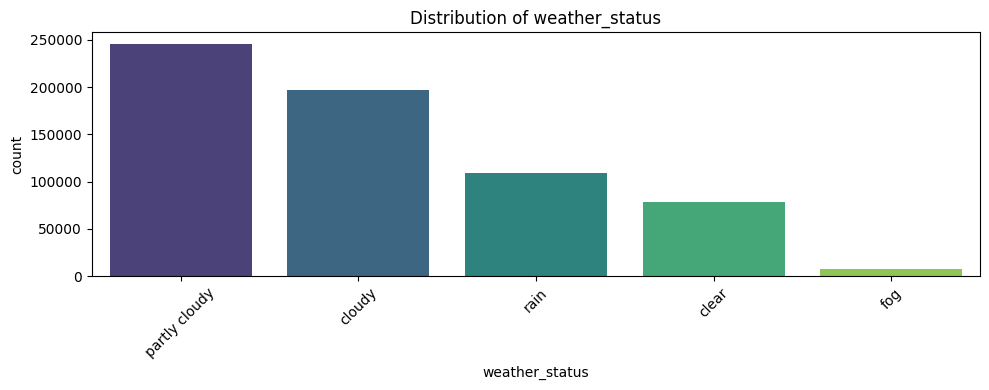

In [8]:
# Categorical features
cat_cols = ['vehicle', 'source', 'destination', 'weather_desc_short', 'weather_status']

# Count plots for categorical variables
for col in cat_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette="viridis")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## **Bivariate Analysis**

## **Fare vs Distance**

In this step, we analyze the relationship between the target variable `fare` and other features to uncover potential patterns and associations.

We'll explore:
- Correlation between `fare` and numerical variables like `distance`, `temperature`, etc.
- How `fare` varies across different categories such as `vehicle type`, `source`, and `weather`.


Correlation with Fare:
 fare                1.000000
distance            0.336011
surge_multiplier    0.236854
visibility          0.001457
wind_speed          0.000978
month               0.000872
cloud_cover         0.000854
pressure            0.000754
hour                0.000630
temperature_C      -0.000091
uv_index           -0.000467
humidity           -0.001230
Name: fare, dtype: float64


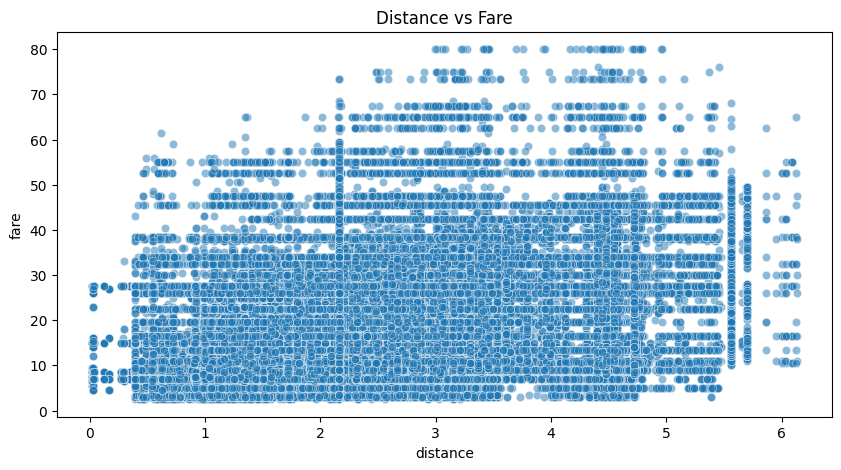

In [9]:
# Correlation of fare with numerical features
corr_with_fare = df.corr(numeric_only=True)["fare"].sort_values(ascending=False)
print("Correlation with Fare:\n", corr_with_fare)

# Scatter plot: Distance vs Fare
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="distance", y="fare", alpha=0.5)
plt.title("Distance vs Fare")
plt.show()

To understand the relationship between fare and distance, We plotted the distance vs fare and calculated correlation of fare with other numerical features. Features except distance doesn't show correalation. The overall fare vs distance correlation coefficient is 0.33, indicating a weak to moderate linear relationship. This suggests that distance alone does not fully explain fare variations.
Several other factors influence the final fare, including the ride company and the type of vehicle used. For example, luxury vehicles typically charge higher rates for the same distance compared to standard vehicles. Therefore, it's important to consider these variables when analyzing fare patterns.

In [10]:
print(f"Lyft:\n {df[df["ride_company"]=='Lyft'][["fare","distance"]].corr()}" )
print(f"Uber:\n {df[df["ride_company"]=='Uber'][["fare","distance"]].corr()}" )

Lyft:
               fare  distance
fare      1.000000  0.358604
distance  0.358604  1.000000
Uber:
               fare  distance
fare      1.000000  0.312418
distance  0.312418  1.000000


Difference in Ride company don't change the correlation much.

In [11]:
df["vehicle"].unique()

array(['Lux Black', 'Lux', 'WAV', 'Lux Black XL', 'Lyft', 'UberX',
       'Shared', 'UberXL', 'Black SUV', 'Black', 'Lyft XL', 'UberPool'],
      dtype=object)

In [12]:
for vehicle in df["vehicle"].unique():
    print(f"{vehicle}: {df[df["vehicle"]==vehicle][["fare","distance"]].corr()["fare"]["distance"].round(2)}")

Lux Black: 0.81
Lux: 0.83
WAV: 0.69
Lux Black XL: 0.7
Lyft: 0.77
UberX: 0.69
Shared: 0.64
UberXL: 0.75
Black SUV: 0.78
Black: 0.85
Lyft XL: 0.81
UberPool: 0.63


All vehicle types show a strong positive correlation between fare and distance.

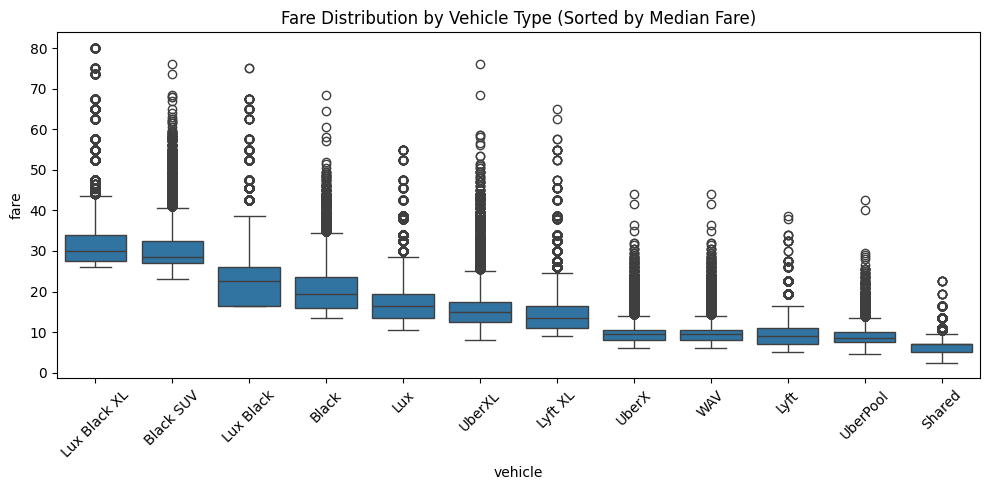

In [13]:
# Calculate median fare per vehicle
median_fares = df.groupby("vehicle")["fare"].median().sort_values(ascending=False)

# Plot sorted boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="vehicle", y="fare", order=median_fares.index)
plt.title("Fare Distribution by Vehicle Type (Sorted by Median Fare)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
fare_stats = df.groupby("vehicle")["fare"].describe().T
fare_stats = fare_stats.loc[:, df.groupby("vehicle")["fare"].mean().sort_values(ascending=False).index]

fare_stats

vehicle,Lux Black XL,Black SUV,Lux Black,Black,Lux,UberXL,Lyft XL,UberX,WAV,Lyft,UberPool,Shared
count,51216.000000,54987.000000,51199.000000,54986.000000,51203.000000,55018.000000,51192.000000,54974.000000,54992.000000,51199.000000,55019.000000,51209.000000
mean,32.288641,30.288223,23.060549,20.527716,17.773295,15.682149,15.311107,9.767217,9.766802,9.611705,8.753222,6.029839
std,7.004740,4.813777,6.462028,4.949849,5.287197,4.522154,4.553503,2.463813,2.463573,2.529145,2.104238,2.105067
min,26.000000,23.000000,16.500000,13.500000,10.500000,8.000000,9.000000,6.000000,6.000000,5.000000,4.500000,2.500000
25%,27.500000,27.000000,16.500000,16.000000,13.500000,12.500000,11.000000,8.000000,8.000000,7.000000,7.500000,5.000000
50%,30.000000,28.500000,22.500000,19.500000,16.500000,15.000000,13.500000,9.500000,9.500000,9.000000,8.500000,7.000000
75%,34.000000,32.500000,26.000000,23.500000,19.500000,17.500000,16.500000,10.500000,10.500000,11.000000,10.000000,7.000000
max,80.000000,76.000000,75.000000,68.500000,55.000000,76.000000,65.000000,44.000000,44.000000,38.500000,42.500000,22.500000


High end vehicles have higher min and mean fare.

## **Fare vs Destination & Source**

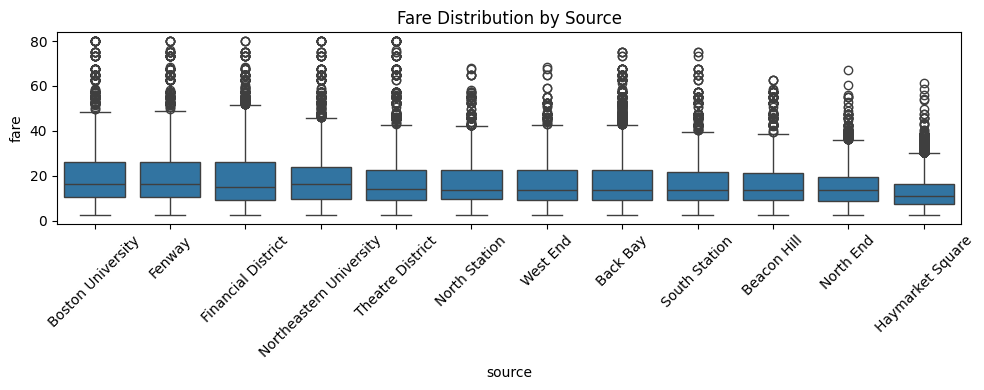

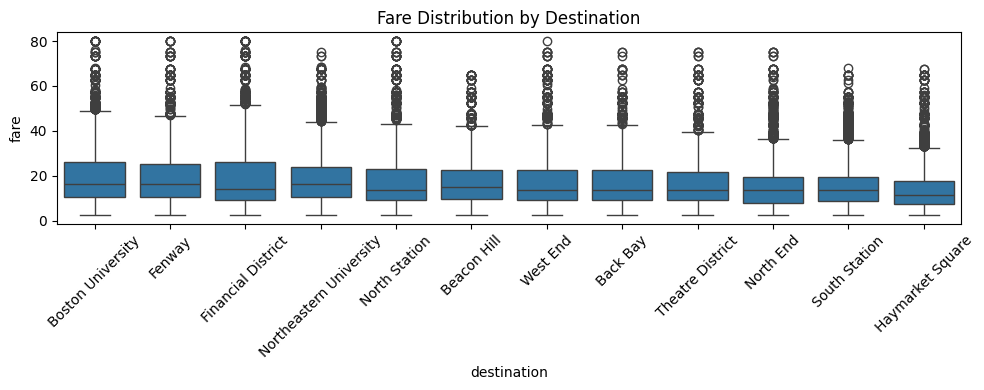

In [15]:
# Source
plt.figure(figsize=(10, 4))
order = df.groupby("source")["fare"].mean().sort_values(ascending=False).index
sns.boxplot(data=df, x="source", y="fare", order=order)
plt.title("Fare Distribution by Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Destination
plt.figure(figsize=(10, 4))
order = df.groupby("destination")["fare"].mean().sort_values(ascending=False).index
sns.boxplot(data=df, x="destination", y="fare", order=order)
plt.title("Fare Distribution by Destination")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Compute fare per unit distance
df["fare_per_km"] = df["fare"] / df["distance"]

# Create a pivot table: source vs vehicle with mean fare/distance
fare_ratio_pivot = df.pivot_table(index="source", columns="vehicle", values="fare_per_km", aggfunc="mean")

# Calculate row-wise sum to sort the table
row_sum = fare_ratio_pivot.sum(axis=1)

# Sort rows by total fare_per_distance
fare_ratio_pivot = fare_ratio_pivot.loc[row_sum.sort_values(ascending=False).index]

# Sort columns by total fare_per_distance
col_sum = fare_ratio_pivot.sum(axis=0)
fare_ratio_pivot = fare_ratio_pivot[col_sum.sort_values(ascending=False).index]

# Display the table
fare_ratio_pivot.style.background_gradient(cmap="YlOrRd")


vehicle,Black SUV,Lux Black XL,Lux Black,Black,Lux,UberXL,Lyft XL,WAV,UberX,Lyft,UberPool,Shared
source,,,,,,,,,,,,
Haymarket Square,32.114684,29.101983,18.417441,19.031546,13.010151,13.346573,11.308953,9.208553,9.211720,7.823536,8.592401,4.607147
Financial District,24.711076,23.783188,15.474986,15.427363,11.204851,10.716827,9.517297,7.189602,7.190506,6.484143,6.278286,3.798938
South Station,21.681032,21.645315,14.605610,13.634029,10.748271,9.988477,9.396318,6.584535,6.570822,6.194884,5.589534,3.769175
Theatre District,21.621720,19.692911,13.611879,13.673372,10.004211,10.218077,8.762991,6.671813,6.675367,5.703358,6.283837,3.492159
North End,20.432311,19.410913,13.172185,12.823287,10.295004,9.733270,8.936600,6.399867,6.400173,5.645373,5.885324,3.469026
Back Bay,19.548418,18.900142,12.825510,12.702900,9.855183,9.532586,8.695810,6.248187,6.205426,5.390428,5.615507,3.384623
North Station,19.790945,18.231589,12.305308,12.683419,9.304524,9.083670,7.969621,5.827899,5.824908,5.155005,5.297544,3.156292
West End,19.034062,18.088840,12.316772,12.259151,9.350547,9.001416,8.021846,5.771256,5.769428,5.179661,5.352413,3.207966
Beacon Hill,14.764686,15.369255,10.889816,9.980195,8.389442,7.722121,7.240949,4.885501,4.889797,4.603550,4.478267,2.957487


We uncovered a consistent and meaningful pattern: the average price-to-distance ratio varies notably across different source locations. This disparity is not random—it holds true across all vehicle categories, indicating a systemic pricing behavior based on pickup location.

Source locations with higher price/distance ratios—such as Haymarket Square, Financial District, and South Station—are predominantly commercial zones. These areas are characterized by high traffic, dense transit access, office clusters, shopping centers, and tourist activity. The elevated fare in these zones likely reflects greater ride demand, frequent congestion, and limited transportation alternatives.

On the other hand, areas with lower price/distance ratios, including Fenway, Northeastern University, and Boston University, tend to be residential or academic neighborhoods. These locations typically have lower ride demand, less traffic, and a calmer urban environment, which keeps fare rates more stable and affordable.

This analysis highlights that location, traffic intensity, and local demand significantly influence fare behavior, beyond just the vehicle type or distance traveled.

In [17]:
df_valid = df.copy()
# Compute fare per unit distance
df_valid["fare_per_distance"] = df_valid["fare"] / df_valid["distance"]

# Create a pivot table: source vs vehicle with mean fare/distance
fare_ratio_pivot = df_valid.pivot_table(index="destination", columns="vehicle", values="fare_per_distance", aggfunc="mean")

# Calculate row-wise sum to sort the table
row_sum = fare_ratio_pivot.sum(axis=1)

# Sort rows by total fare_per_distance
fare_ratio_pivot = fare_ratio_pivot.loc[row_sum.sort_values(ascending=False).index]

# Sort columns by total fare_per_distance
col_sum = fare_ratio_pivot.sum(axis=0)
fare_ratio_pivot = fare_ratio_pivot[col_sum.sort_values(ascending=False).index]

# Display the taorder = df.groupby("destination")["fare"].mean().sort_values(ascending=False).indexble
fare_ratio_pivot.style.background_gradient(cmap="YlOrRd")

vehicle,Black SUV,Lux Black XL,Lux Black,Black,Lux,UberXL,Lyft XL,UberX,WAV,Lyft,UberPool,Shared
destination,,,,,,,,,,,,
South Station,30.712449,29.231138,19.069864,18.607698,13.378040,12.820137,11.629394,8.792427,8.767993,8.117763,8.006421,4.798440
Haymarket Square,26.706251,24.606498,15.928414,16.196543,11.697284,11.863938,10.306295,7.833411,7.840890,6.743828,7.237863,4.026435
Financial District,21.700255,21.566225,14.272560,13.315552,10.347345,9.696469,9.054566,6.443307,6.449687,5.998655,5.392956,3.493241
North Station,21.383772,21.123645,14.137115,13.369515,10.320176,9.534173,8.781972,6.255708,6.256165,5.889586,5.603524,3.572821
North End,19.822352,20.075803,13.345472,12.391821,10.507609,9.460329,8.856799,6.028041,6.029509,5.668320,5.593806,3.467307
West End,19.716729,18.845260,12.899119,12.338289,9.547773,9.163129,8.341606,5.943466,5.948496,5.438809,5.241261,3.354261
Theatre District,18.439621,17.378374,12.248795,11.829748,9.539882,9.195484,8.311948,5.844406,5.844240,5.214979,5.338029,3.230428
Back Bay,18.130669,16.257320,11.157749,11.655408,8.805771,8.769043,7.563986,5.709453,5.663316,4.675145,4.951835,2.972314
Beacon Hill,14.857352,14.934851,10.569212,9.837749,8.186575,7.592986,7.103435,4.848702,4.846398,4.490123,4.377296,2.864266


We observed a similar fare pattern when grouped by destination: locations with the highest average price-per-distance ratio as destinations were also those that ranked highest as sources. This consistent structure suggests that both pickup and drop-off locations influence fare significantly.

Busy commercial areas—such as business districts, transit hubs, and tourist spots—tend to have higher fares, regardless of whether they are the origin or destination of a ride. 

In [18]:
ride_counts = pd.crosstab(df["source"], df["destination"])
ride_counts.style.background_gradient(cmap="Blues")


destination,Back Bay,Beacon Hill,Boston University,Fenway,Financial District,Haymarket Square,North End,North Station,Northeastern University,South Station,Theatre District,West End
source,,,,,,,,,,,,
Back Bay,0,0,8674,8695,0,8836,9408,0,8816,8715,0,0
Beacon Hill,0,0,8476,8677,0,8792,9233,0,8912,8695,0,0
Boston University,8664,8472,0,0,8937,0,0,8714,0,0,9160,9155
Fenway,8703,8680,0,0,8907,0,0,8958,0,0,8502,9350
Financial District,0,0,8933,8916,0,9313,8584,0,8868,9509,0,0
Haymarket Square,8835,8796,0,0,9317,0,0,8838,0,0,8872,8416
North End,9412,9232,0,0,8589,0,0,8652,0,0,8750,8478
North Station,0,0,8719,8958,0,8853,8664,0,8901,8404,0,0
Northeastern University,8811,8903,0,0,8873,0,0,8896,0,0,8872,8764


Another interesting insight from the dataset is the ride distribution across location pairs. The total number of rides between various source and destination combinations is remarkably balanced—most pairs have very similar ride counts, often in the range of 8,000 to 9,500.

However, rides are concentrated only among 72 specific source-destination pairs, while several combinations show zero rides, indicating that not all location pairs are equally connected in this dataset. This suggests a structured and limited travel pattern, possibly reflecting common commuting routes, urban layout, or user demand behavior.

## **Fare vs Time**

/tmp/ipykernel_11823/3540493154.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="hour", y="fare_per_km", estimator='mean', ci=None)


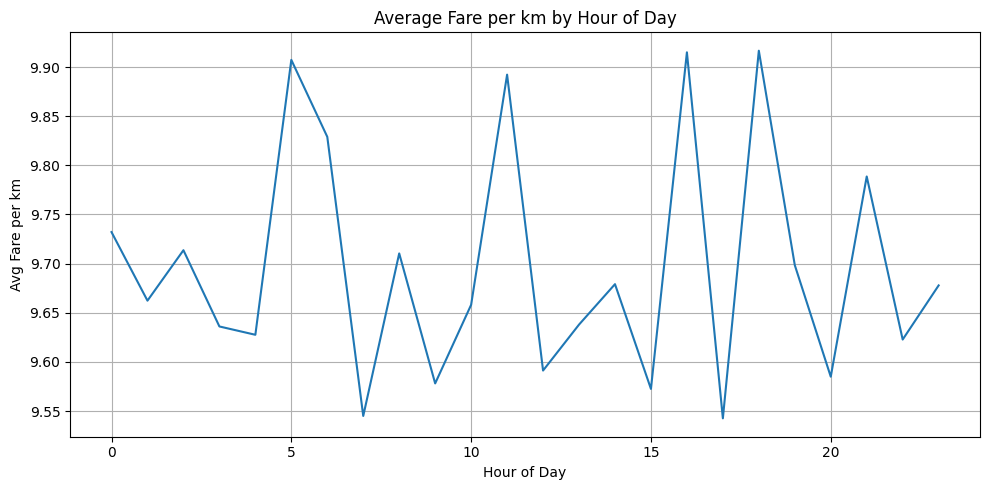

In [19]:
df["fare_per_km"] = df["fare"] / df["distance"] 

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="hour", y="fare_per_km", estimator='mean', ci=None)
plt.title("Average Fare per km by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Fare per km")
plt.grid(True)
plt.tight_layout()
plt.show()

The average fare per kilometer remains consistent throughout the day, ranging narrowly between `$9.55` and `$9.90`. There is no significant deviation or discernible pattern across different hours, indicating that time of day does not substantially impact the fare rate per kilometer in this dataset.

/tmp/ipykernel_11823/2524840215.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="day_of_week", y="fare_per_km", estimator='mean', ci=None)


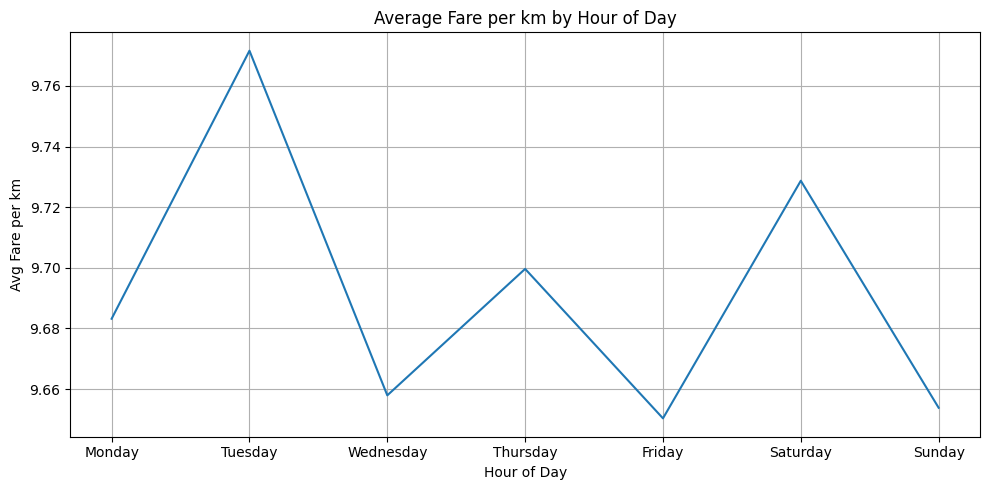

In [20]:
df["fare_per_km"] = df["fare"] / df["distance"] 

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="day_of_week", y="fare_per_km", estimator='mean', ci=None)
plt.title("Average Fare per km by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Fare per km")
plt.grid(True)
plt.tight_layout()
plt.show()

The variation in fare across different days of the week is minimal, with average fares per kilometer ranging only from 9.65 to 9.77. Combined with the earlier observation that fare remains consistent across different hours of the day, we can conclude that neither the time of day nor the day of the week has any significant impact on fare in this dataset.

## **Fare vs Weather Description**

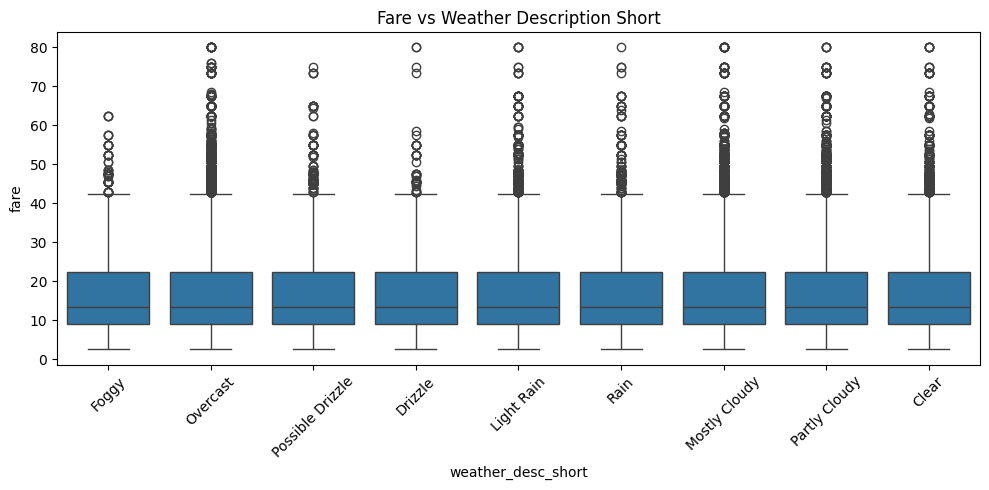

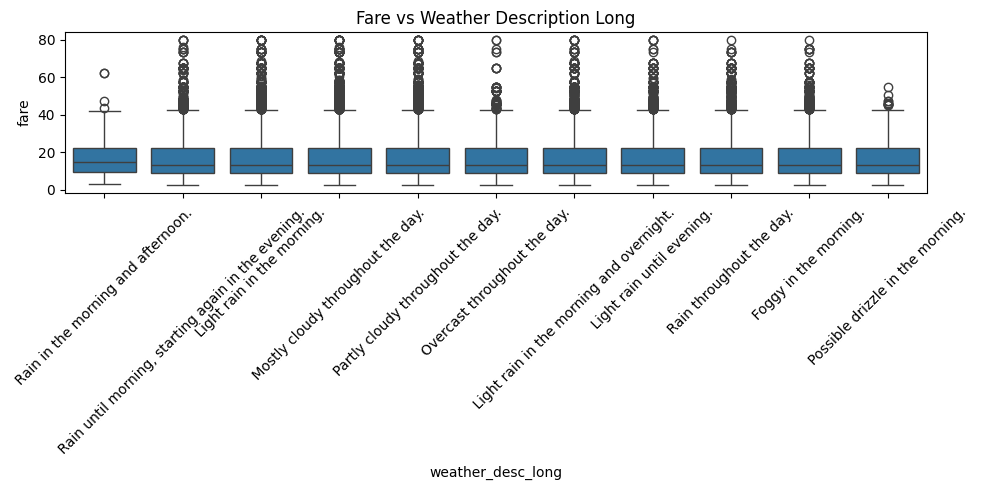

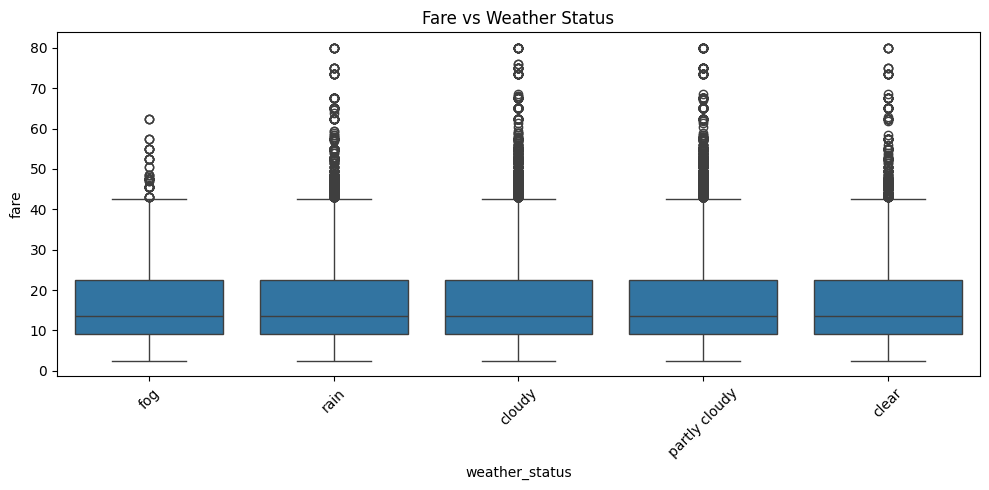

In [21]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="weather_desc_short", y="fare")
plt.title("Fare vs Weather Description Short")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="weather_desc_long", y="fare")
plt.title("Fare vs Weather Description Long")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="weather_status", y="fare")
plt.title("Fare vs Weather Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
fare_stats = df.groupby("weather_desc_short")["fare"].describe().T
fare_stats = fare_stats.loc[:, df.groupby("weather_desc_short")["fare"].mean().sort_values(ascending=False).index]

fare_stats

weather_desc_short,Mostly Cloudy,Light Rain,Partly Cloudy,Foggy,Rain,Overcast,Drizzle,Clear,Possible Drizzle
count,134443.000000,50413.000000,117079.000000,8280.000000,21749.000000,201183.000000,6718.000000,80188.000000,17141.00000
mean,16.593211,16.560718,16.553710,16.543961,16.539931,16.532708,16.506698,16.483730,16.47721
std,9.356010,9.325990,9.301881,9.226557,9.295840,9.297348,9.264445,9.268089,9.26260
min,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.50000
25%,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000
50%,13.500000,13.500000,13.500000,13.500000,13.500000,13.500000,13.500000,13.500000,13.50000
75%,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.500000,22.50000
max,80.000000,80.000000,80.000000,62.500000,80.000000,80.000000,80.000000,80.000000,75.00000


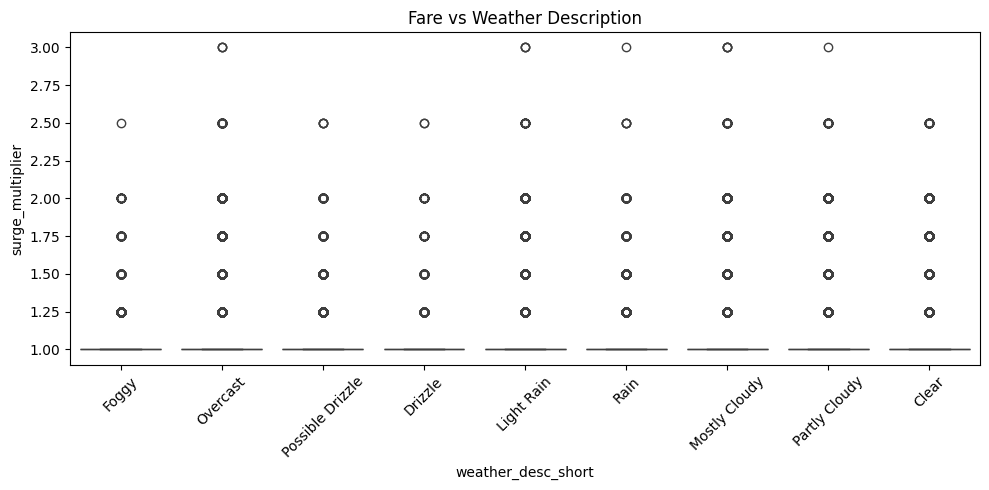

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="weather_desc_short", y="surge_multiplier")
plt.title("Fare vs Weather Description")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
temp_df = df[df["surge_multiplier"]>1]
temp_df.groupby("weather_desc_short")["surge_multiplier"].count() / df.groupby("weather_desc_short")["surge_multiplier"].count() * 100

weather_desc_short
Clear               3.424453
Drizzle             2.902650
Foggy               3.792271
Light Rain          3.173785
Mostly Cloudy       3.417805
Overcast            3.183669
Partly Cloudy       3.314856
Possible Drizzle    3.202847
Rain                3.172560
Name: surge_multiplier, dtype: float64

Our analysis indicates that weather conditions have no significant impact on either fare amounts or surge pricing. The proportion of surge rides remained fairly consistent—ranging from 2.9% to 3.8%—across all weather types. Additionally, summary statistics and boxplot distributions of fare grouped by weather_desc_short, weather_desc_long, and weather_status showed no meaningful variation.

Although some influence from weather was expected, surprisingly, the data reveals no observable relationship between weather and fare behavior. Since weather_desc_short, weather_desc_long, and weather_status convey overlapping information, and none contribute to fare prediction, we can confidently drop the three columns.

In [25]:
df = df.drop(columns=["weather_desc_long","weather_desc_short","weather_status"], axis=1, inplace=False)

## **Fare vs Weather Features**

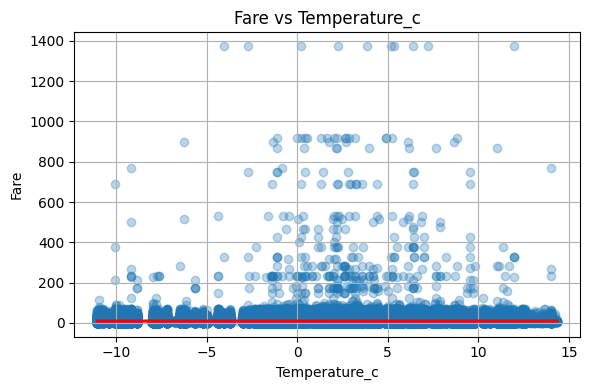

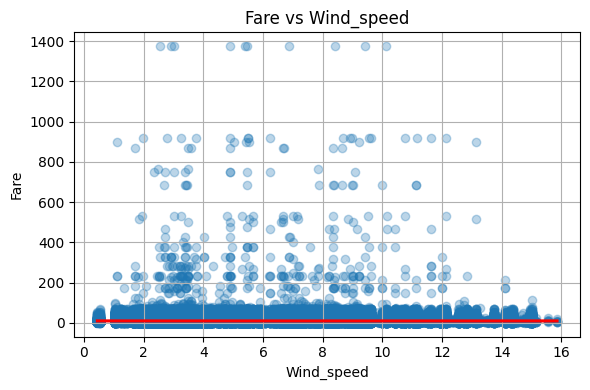

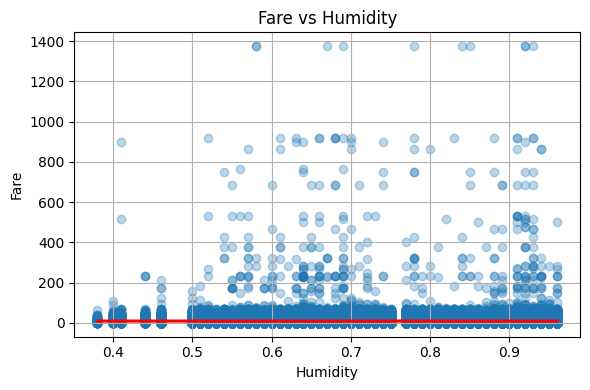

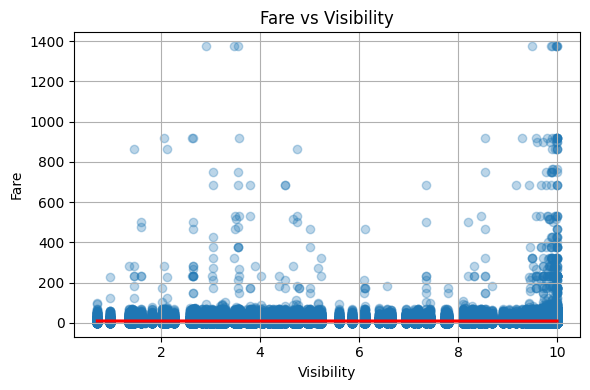

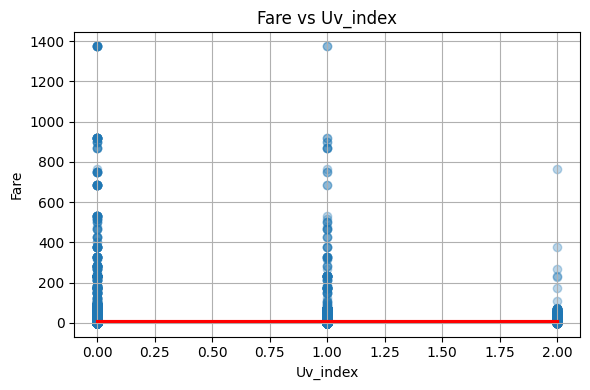

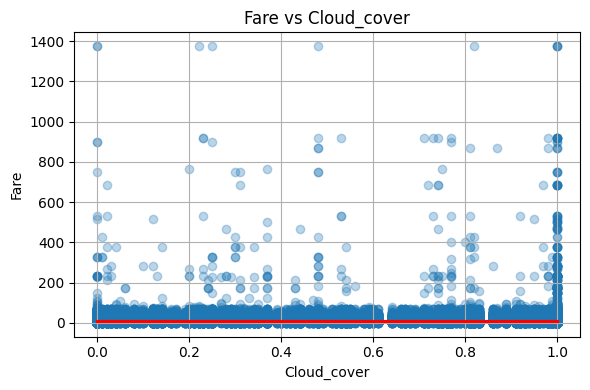

In [26]:
features = ["temperature_C", "wind_speed", "humidity", "visibility", "uv_index", "cloud_cover"]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=df, x=feature, y="fare_per_km", scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
    plt.title(f"Fare vs {feature.capitalize()}")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Fare")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We analyzed the relationship between fare and several continuous weather-related features: temperature, wind speed, humidity, visibility, UV index, and cloud cover. Scatter plots with regression lines were generated for each feature.

Across all weather variables, the regression lines were nearly flat and parallel to the x-axis, indicating no linear relationship between fare and these weather conditions. The fare distribution remained constant regardless of changes in weather parameters. This reinforces earlier findings that weather does not influence fare pricing in this dataset.

In [27]:
df.columns

Index(['timestamp', 'date', 'hour', 'day_of_week', 'month', 'source',
       'destination', 'ride_company', 'vehicle', 'visibility', 'cloud_cover',
       'uv_index', 'distance', 'surge_multiplier', 'fare', 'humidity',
       'wind_speed', 'pressure', 'temperature_C', 'fare_per_km'],
      dtype='object')

## **Explore Surge Multiplier**

In [28]:
df["surge_multiplier"].describe()

count    637194.000000
mean          1.015086
std           0.095479
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: surge_multiplier, dtype: float64

In [29]:
df["surge_multiplier"].unique()

array([1.75, 1.  , 1.25, 1.5 , 2.  , 2.5 , 3.  ])

surge_multiplier
1.00    616219
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: count, dtype: int64

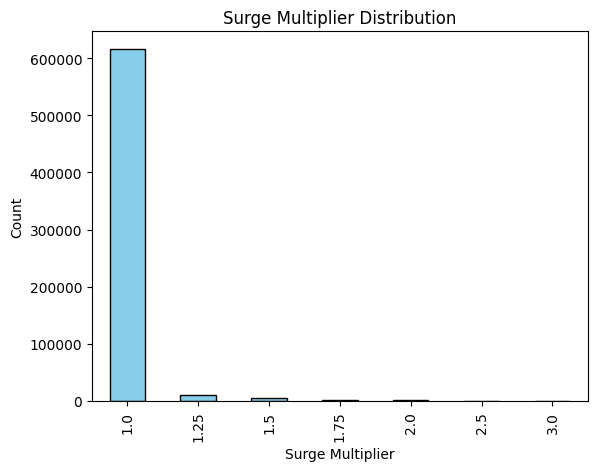

In [30]:
x = df["surge_multiplier"].value_counts()
x.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Surge Multiplier Distribution')
plt.xlabel('Surge Multiplier')
plt.ylabel('Count')
x

The suge_multipliers are multiple of 0.25.

In [31]:
surge_rides = df[df["surge_multiplier"]>1]
surge_vehicles = surge_rides["vehicle"].unique()

print("Ride Comapny: ",surge_rides["ride_company"].unique())
print("Ride Vehicles: ",surge_vehicles)

surge_rides.head()

Ride Comapny:  ['Lyft']
Ride Vehicles:  ['Lux Black' 'Lux' 'Lyft XL' 'Lyft' 'Lux Black XL']


,timestamp,date,hour,day_of_week,month,source,destination,ride_company,vehicle,visibility,cloud_cover,uv_index,distance,surge_multiplier,fare,humidity,wind_speed,pressure,temperature_C,fare_per_km
0,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,Lux Black,1.685,1.0,0,4.46,1.75,62.5,0.92,0.51,1014.10,5.46,14.013453
1,2018-11-26 03:40:46,2018-11-26,3,Monday,11,Boston University,Financial District,Lyft,Lux,1.685,1.0,0,4.46,1.75,47.5,0.92,0.51,1014.10,5.46,10.650224
22,2018-11-26 03:40:47,2018-11-26,3,Monday,11,Fenway,Beacon Hill,Lyft,Lyft XL,1.685,1.0,0,2.40,1.25,19.5,0.92,0.51,1014.10,5.46,8.125000
38,2018-11-26 03:40:47,2018-11-26,3,Monday,11,Back Bay,Fenway,Lyft,Lux,1.685,1.0,0,1.66,1.75,26.0,0.92,0.51,1014.10,5.46,15.662651
78,2018-11-26 04:40:55,2018-11-26,4,Monday,11,Boston University,Beacon Hill,Lyft,Lyft,4.159,1.0,0,2.70,1.25,11.0,0.90,0.45,1014.06,5.29,4.074074


So, Uber doesn't have surge_multiplier. It is only for lyft. And, the surge is applied to only high end vehicles of Lyft.

In [32]:
print(f"{len(surge_rides)/len(df)*100}%")

3.2917761309742404%


Majority value is 1. Only 3.29% of the total data have surge_multiplier>1. And surge_multiplier is multiple of 0.25. 

In [33]:
print(f"{len(surge_rides)/ len(df[df["vehicle"].isin(surge_vehicles)])*100}%")

8.193071337335796%


Of the rides from vehicles eligible for surge pricing, 8.19% of the rides experienced surge in fares.

In [34]:
surge_rides["vehicle"].value_counts()

vehicle
Lux Black       4195
Lux             4195
Lyft XL         4195
Lyft            4195
Lux Black XL    4195
Name: count, dtype: int64

The surge mutiplication is eveny distributed among the particular vehicles.

In [35]:
df[df["vehicle"].isin(surge_vehicles)]["vehicle"].value_counts()

vehicle
Lux Black XL    51216
Lux             51203
Lux Black       51199
Lyft            51199
Lyft XL         51192
Name: count, dtype: int64

In [36]:
surge_rides["vehicle"].value_counts()/df[df["vehicle"].isin(surge_vehicles)]["vehicle"].value_counts()*100

vehicle
Lux             8.192879
Lux Black       8.193519
Lux Black XL    8.190800
Lyft            8.193519
Lyft XL         8.194640
Name: count, dtype: float64

Surge fares are evenly distributed across the selected vehicle types, with approximately 8.19% of rides in each experiencing surge pricing.

In [37]:
# sns.heatmap(surge_rides.corr(numeric_only=True))
surge_rides.corr(numeric_only=True)["surge_multiplier"]

hour                0.003744
month              -0.006724
visibility         -0.000807
cloud_cover         0.007019
uv_index            0.009851
distance            0.053511
surge_multiplier    1.000000
fare                0.343194
humidity            0.004006
wind_speed          0.017382
pressure           -0.014527
temperature_C      -0.003264
fare_per_km         0.197416
Name: surge_multiplier, dtype: float64

Surge_multiplier has 0 correalation with weather data. It is not applied depending on the weather condition.

source
Back Bay                   5.400421
Northeastern University    5.007624
Fenway                     4.952919
Boston University          4.651426
Theatre District           4.632070
Beacon Hill                3.883679
South Station              3.199940
Financial District         2.780703
West End                   1.861969
North Station              1.609554
Haymarket Square           0.772506
North End                  0.734284
Name: surge_multiplier, dtype: float64


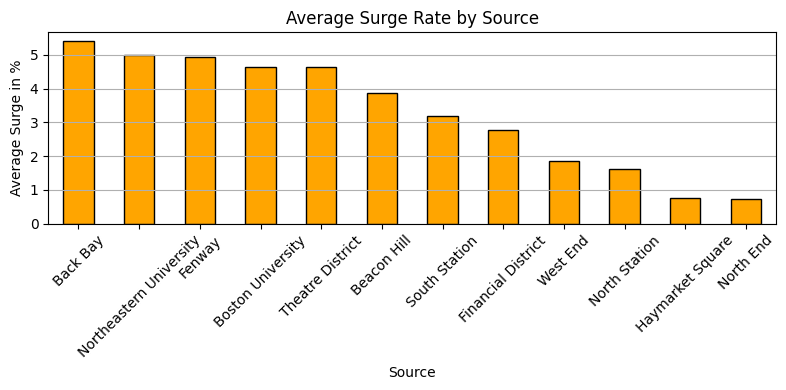

In [38]:
# Grouped and sorted values for source location
grouped = df.groupby("source")["surge_multiplier"].apply(lambda x: (x > 1).mean()).sort_values(ascending=False) * 100
print(grouped)

plt.figure(figsize=(8, 4))
grouped.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Average Surge Rate by Source')
plt.xlabel('Source')
plt.ylabel('Average Surge in %')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

While busy commercial areas like Back Bay and Theatre District do show higher surge percentages, others like Financial District and South Station have relatively low surge frequencies. Conversely, academic and residential zones like Northeastern University and Boston University exhibit higher surge rates. This suggests that surge pricing may be more influenced by vehicle availability than just demand—locations with fewer available drivers, despite being less busy overall, may trigger surge more frequently. In contrast, commercial zones have higher regular fare but less frequently have surge in fare.

destination
Boston University          3.549906
North End                  3.503419
Theatre District           3.387279
Fenway                     3.362468
Northeastern University    3.293746
Financial District         3.287590
Back Bay                   3.265145
Haymarket Square           3.249261
South Station              3.222584
North Station              3.182165
Beacon Hill                3.107002
West End                   3.087819
Name: surge_multiplier, dtype: float64


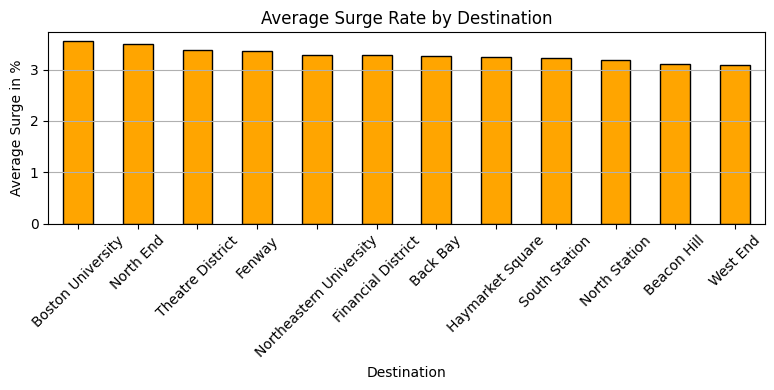

In [39]:
# Grouped and sorted values for source location
grouped = df.groupby("destination")["surge_multiplier"].apply(lambda x: (x > 1).mean()).sort_values(ascending=False) * 100
print(grouped)
plt.figure(figsize=(8, 4))
grouped.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Average Surge Rate by Destination')
plt.xlabel('Destination')
plt.ylabel('Average Surge in %')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Surge rates by destination vary only slightly, ranging from 3.08% to 3.55%, showing no strong link to the type of area—whether commercial or residential. In contrast, source locations show more variation, suggesting that surge pricing is primarily driven by supply-demand imbalances at the pickup point rather than traffic or business activity at the destination. This may indicate limited vehicle availability in residential or university areas, leading to more frequent surge pricing there.

### **Surge vs Time**

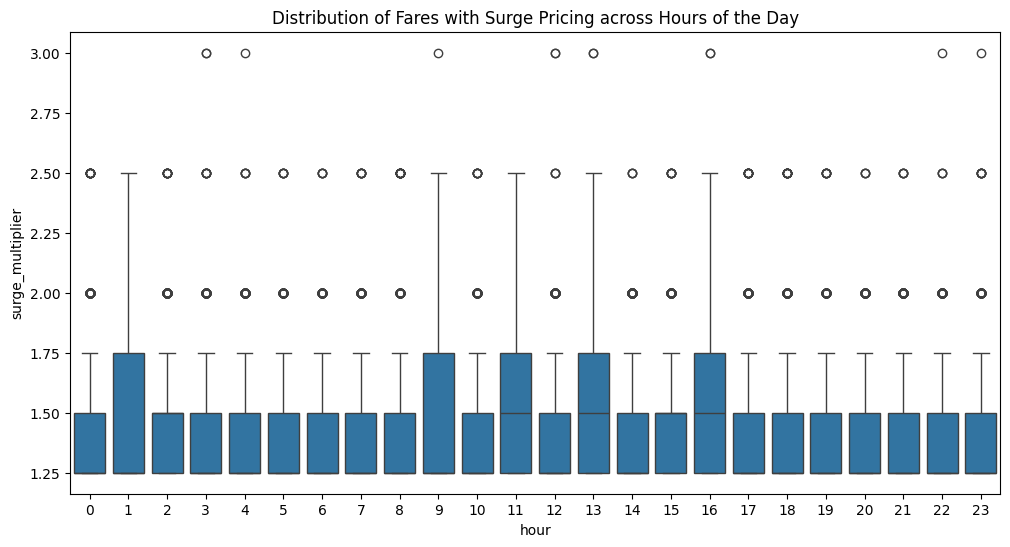

In [40]:
plt.figure(figsize=(12,6))
sns.boxplot(data=surge_rides, x="hour", y="surge_multiplier")
plt.title("Distribution of Fares with Surge Pricing across Hours of the Day")
plt.show()

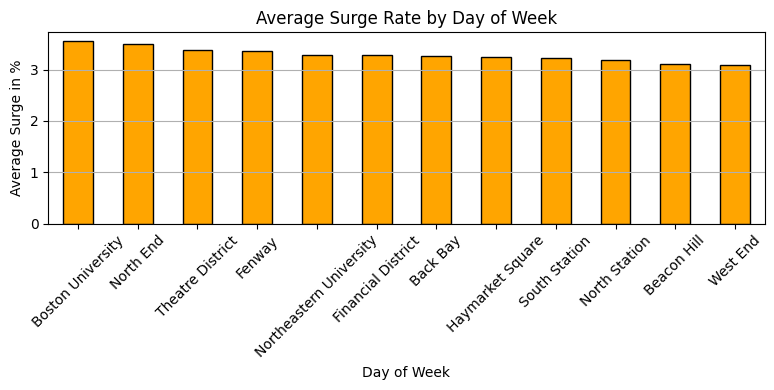

In [41]:
# Grouped and sorted values for day of week
grouped = df.groupby("destination")["surge_multiplier"].apply(lambda x: (x > 1).mean()).sort_values(ascending=False) * 100

plt.figure(figsize=(8, 4))
grouped.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Average Surge Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Surge in %')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

From the above charts, It's seen that surge doesn't depend on hour or day of the week. 

### **Surge vs Fare & Distance**

Text(0.5, 1.0, 'Fare comparison: With Surge vs Without Surge')

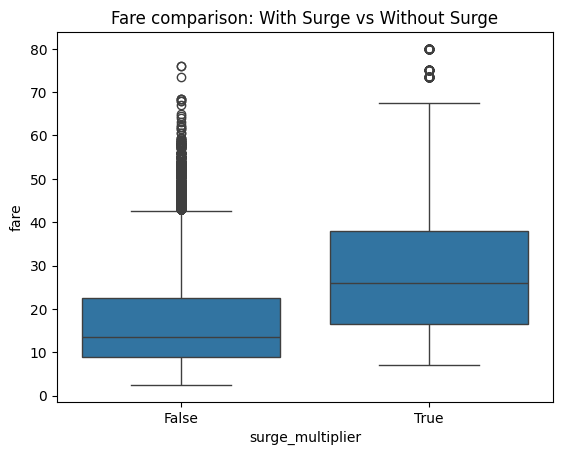

In [42]:
sns.boxplot(x=df["surge_multiplier"]>1, y="fare", data=df)
plt.title("Fare comparison: With Surge vs Without Surge")

For, surged rides, regular fare is multiplied with surge multiplier. So, it was expected to see overall higher fare in surged rides.

Text(0.5, 1.0, 'Distance comparison: With Surge vs Without Surge')

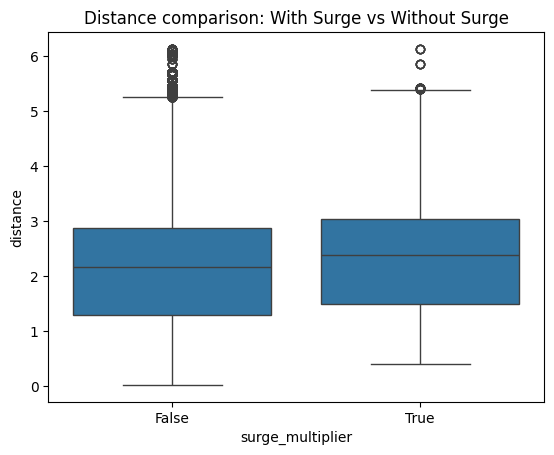

In [43]:
sns.boxplot(x=df["surge_multiplier"]>1, y="distance", data=df)
plt.title("Distance comparison: With Surge vs Without Surge")

Surge is slightly more seen in higher distances. But, No useful information could be derived from this stat.

## **Multivariate Analysis**

hour                0.000630
month               0.000872
visibility          0.001457
cloud_cover         0.000854
uv_index           -0.000467
distance            0.336011
surge_multiplier    0.236854
fare                1.000000
humidity           -0.001230
wind_speed          0.000978
pressure            0.000754
temperature_C      -0.000091
fare_per_km         0.245198
Name: fare, dtype: float64


<Axes: >

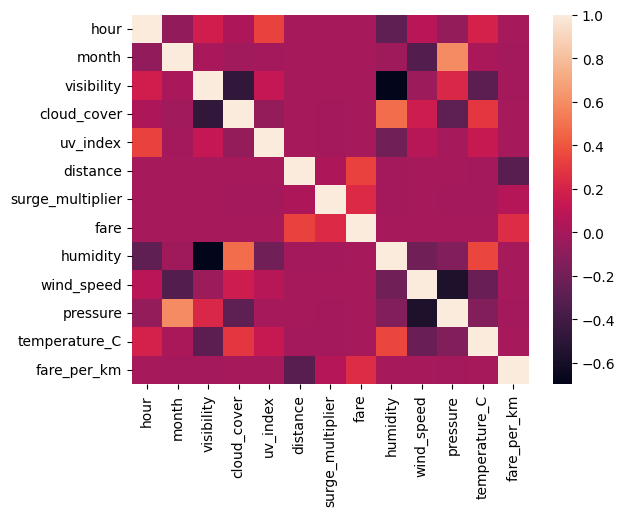

In [44]:
print(df.corr(numeric_only=True)["fare"])
sns.heatmap(df.corr(numeric_only=True))

Our target variable fare has no correalation with any numerical feature except distance.

# 📊 Exploratory Data Analysis Summary

## 🚖 1. Fare Patterns by Location
- **Source Matters:** Fare per kilometer is not constant across pickup locations. High-traffic commercial areas like Haymarket Square, Financial District, South Station, and Theatre District consistently show higher fare per distance.
- **Residential & Academic Areas:** Locations such as Fenway, Northeastern University, and Boston University have lower fare per km, possibly due to lower demand or reduced traffic.
- **Destination Impact:** Similar trends are observed in destination fares. Both pickup and drop-off locations influence overall fare, though source has a stronger effect.

## 📌 2. Route-Level Ride Patterns
- Only 72 unique source-destination pairs exist, meaning rides are limited to specific combinations.
- Ride counts between these combinations are very balanced, suggesting a controlled or engineered distribution
## ⏰ 3. Time of Day and Day of Week
- **Hourly Analysis:** Average fare per km remains consistent throughout the day, ranging from **9.55 to 9.9 USD/km**.
- **Weekly Trend:** Fare per km is also stable across days, ranging from **9.65 to 9.77 USD/km**.
- ➤ **Conclusion:** Neither time of day nor day of week significantly affects fare.

## 🌦️ 4. Weather Variables
- Features like **temperature, humidity, wind speed, visibility, UV index, and cloud cover** show **no linear correlation** with fare.
- Regression lines are nearly flat across all plots.
- ➤ Suggests weather conditions do not influence fare in this dataset.

## 💸 5. Surge Pricing Analysis
- Only **3.29%** of all rides had a surge multiplier > 1.
- Among surge-eligible vehicles (e.g., Lux, Lux Black, Lyft XL), about **8.19%** of rides experienced surge pricing.
- Surge application is evenly distributed across all high-end vehicle types.

## 🧭 6. Surge by Source & Destination
- **Surge by Source:** Pickup location strongly affects surge. For example:
  - **Back Bay:** 5.4%
  - **Northeastern University:** 5.0%
  - **North End:** 0.7%
- High-traffic commercial areas tend to have lower surge rates, likely due to better vehicle supply.
- Residential or university areas see more frequent surge, suggesting vehicle shortages in those zones.
- **Surge by Destination:** Rates are uniform (3.08%–3.55%) across drop-off locations with no clear pattern.
- ➤ Indicates surge pricing is influenced more by pickup location (supply-demand dynamics) than destination.

## 🗺️ 7. Geographic Patterns
- Ride locations are concentrated within a specific urban zone, with well-defined clusters.
- Indicates a compact city region with clear mobility hotspots and corridors.

---

## ✅ Key Takeaways
- Fare and surge pricing are location-dependent, especially influenced by the pickup point.
- Surge pricing is supply-driven, more common in areas with potentially fewer available vehicles.
- Time and weather do not play significant roles in determining fare or surge in this dataset.
- The ride network is well-defined and clustered, reflecting structured movement patterns within the city

<!-- 📊 Exploratory Data Analysis (EDA) Steps
Initial Data Inspection
Load the cleaned dataset.

df.head(), df.tail(), df.sample() – View samples of the data.

df.info() – Check column data types and non-null values.

df.describe() – Get numerical summary statistics.

df.isnull().sum() – Identify missing values.

**Understand the Target Variable (fare)**
Plot distribution: histogram, boxplot.

Check skewness & outliers.

Calculate summary stats: mean, median, IQR, mode. -->

<!-- **Univariate Analysis** -->
<!-- Analyze distribution of key variables: distance, hour, vehicle, surge_multiplier, weather, source, destination.

Use bar plots, histograms, or pie charts depending on the variable type (categorical vs numerical). -->

<!-- **Bivariate Analysis** -->
<!-- Fare vs Distance: -->

<!-- Scatter plot, correlation coefficient. -->

<!-- Group by vehicle type and re-check correlation. -->

<!-- Fare vs Time (hour, day, etc.): -->

<!-- Boxplots or line plots to observe fare changes throughout the day/week. -->

<!-- Fare vs Weather: -->

<!-- Boxplots or violin plots for weather categories. -->

<!-- Fare vs Vehicle Type: -->

<!-- Boxplots by vehicle type. -->

<!-- Surge Multiplier vs Time/Weather: -->

<!-- Check if surge pricing correlates with time/weather patterns. -->

**Multivariate Analysis**
<!-- Use sns.pairplot() or sns.heatmap() to explore relationships among multiple numeric features. -->

<!-- Group by combinations of features (e.g., source, destination, vehicle) to check fare patterns. -->

<!-- **Outlier Analysis**
Use boxplots and thresholds (e.g., IQR, domain knowledge) to detect outliers.

Investigate and handle fare outliers (already partially done).

Identify anomalies for distance, duration, or unexpected combinations (e.g., low distance but very high fare). -->

<!-- **Time-Based Patterns**
Plot fare patterns over hour, day_of_week, or month.

Examine how demand and pricing vary with time. -->

<!-- **Geospatial Trends (if location coordinates available)**
Plot source and destination densities on maps.

Cluster common routes. -->
<!-- 
**Missing/Invalid Data Handling**
Review how you handled missing or noisy entries.

Check if any columns still need imputation or transformation.
 -->
**Feature Engineering Ideas**
Create new variables (e.g., fare_per_mile, is_weekend, ride_duration_category, etc.)

Bin continuous variables (distance, hour) to analyze fare buckets.

**Summary & Insights**
Document key insights:

Which variables influence fare the most?

When do fares spike?

Which vehicle types are most expensive?

Are shared rides cheaper and shorter?